In [1]:
import pandas as pd
import numpy as np

In [58]:
port_date_iter = pd.read_csv("/mnt/c/Users/msses/Desktop/ETF/results_NSGA2/2022_01_03/iter_001/best_portfolio_by_sharpe.csv")
etf_date1 = pd.read_csv("/mnt/c/Users/msses/Desktop/ETF/weekly_log_returns/weekly_log_returns_2022_12_05.csv")
etf_date2 = pd.read_csv("/mnt/c/Users/msses/Desktop/ETF/weekly_log_returns/weekly_log_returns_2023_01_02.csv")
etf = pd.concat([etf_date1, etf_date2])

In [54]:
print(etf.columns)
print(port_date_iter.columns)

Index(['ticker', 'week_start', 'first_price', 'last_price', 'log_return'], dtype='object')
Index(['ticker', 'weight'], dtype='object')


In [59]:
# 1. Garante que 'ticker' é a chave e os pesos somam 1
port = port_date_iter.set_index("ticker")["weight"]
port = port / port.sum()  # normaliza (caso não esteja)

# 2. Filtra apenas os tickers com peso > 0
tickers_port = port[port > 0].index
etf_filtrado = etf[etf["ticker"].isin(tickers_port)].copy()

# 3. Junta o peso ao DataFrame de retornos
etf_filtrado["peso"] = etf_filtrado["ticker"].map(port)

# 4. Calcula a contribuição ponderada de cada ativo
etf_filtrado["retorno_ponderado"] = etf_filtrado["log_return"] * etf_filtrado["peso"]

# 5. Soma os retornos por semana → retorno do portfólio
retorno_portfolio = (
    etf_filtrado
        .groupby("week_start")["retorno_ponderado"]
        .sum()
        .reset_index(name="retorno_portfolio")
)
retorno_portfolio = sum(retorno_portfolio.retorno_portfolio)
print(retorno_portfolio)

0.04554245639357023


In [39]:
# ------------------------------------------------------------
# 0. Imports e configuração de diretórios (WSL)
# ------------------------------------------------------------
from pathlib import Path
import re
import pandas as pd
import numpy as np

BASE_DIR   = Path("/mnt/c/Users/msses/Desktop/ETF")
DIR_RESULTS = BASE_DIR / "results_NSGA2"           # .../AAAA_MM_DD/iter_XXX/...
DIR_ETF     = BASE_DIR / "weekly_log_returns"      # arquivos weekly_log_returns_YYYY_MM_DD.csv
DIR_RF      = BASE_DIR / "DTB1"                    # arquivos rf_weekly_log_returns_YYYY_MM_DD.csv
SP500_PATH  = BASE_DIR / "S&P500" / "HistoricalData_1750724799560.csv"

# ------------------------------------------------------------
# 1. Funções utilitárias
# ------------------------------------------------------------
def monday_of(series: pd.Series) -> pd.Series:
    """Recebe uma Series de datas e retorna a segunda-feira da semana correspondente."""
    return series - pd.to_timedelta(series.dt.weekday, unit="d")

def preparar_sp500(path_sp500: Path) -> pd.Series:
    """
    Lê o CSV diário do S&P 500 (colunas 'Date', 'Close/Last'),
    calcula log-retorno diário e devolve a soma (segunda-sexta) por semana.

    Retorna:
        pd.Series indexada por 'week_start' com nome 'sp500_log_return'.
    """
    # 1) Ler e ordenar
    df = (
        pd.read_csv(path_sp500)
          .assign(Date=lambda d: pd.to_datetime(d["Date"]))
          .sort_values("Date")
          .reset_index(drop=True)
    )

    # 2) Log-retorno diário: ln(P_t / P_{t-1})
    df["log_ret_daily"] = np.log(df["Close/Last"]).diff()

    # 3) Segunda-feira de cada semana (usa a mesma helper dos ETFs)
    df["week_start"] = monday_of(df["Date"])

    # 4) Soma dos logs dentro da semana (segunda-sexta)
    sp500_weekly = (
        df.groupby("week_start")["log_ret_daily"]
          .sum(min_count=1)           # garante NaN se faltar todos os dias
          .dropna()
          .rename("sp500_log_return")
    )

    return sp500_weekly

def calcular_metricas(rets: np.ndarray, rf: np.ndarray, freq: int = 52) -> dict:
    """
    Recebe vetor de retornos do portfólio e vetor de risk-free (mesma length, log-retornos).
    Devolve Sharpe e Sortino anualizados + retorno médio e vol. anualizada.
    """
    excess = rets - rf
    mu           = excess.mean()
    sigma        = rets.std()
    downside_std = np.sqrt(((np.minimum(0, excess))**2).mean())

    sharpe  = (mu * freq) / (sigma        * np.sqrt(freq)) if sigma        > 0 else np.nan
    sortino = (mu * freq) / (downside_std * np.sqrt(freq)) if downside_std > 0 else np.nan

    return {"sharpe_ratio": sharpe, "sortino_ratio": sortino}

def date_from_filename(fname: str) -> str:
    """Extrai AAAA_MM_DD do nome do arquivo."""
    m = re.search(r"\d{4}_\d{2}_\d{2}", fname)
    return m.group(0) if m else ""

# ------------------------------------------------------------
# 2. Pré-carrega listas de arquivos ordenadas por data
# ------------------------------------------------------------
all_etf_files = sorted(DIR_ETF.glob("weekly_log_returns_*.csv"),
                       key=lambda p: date_from_filename(p.name))
all_rf_files  = sorted(DIR_RF .glob("rf_weekly_log_returns_*.csv"),
                       key=lambda p: date_from_filename(p.name))

# Mapeia data_tag → posição dentro da lista (útil p/ achar janelas futuras)
idx_etf_by_tag = {date_from_filename(p.name): i for i, p in enumerate(all_etf_files)}

# S&P 500 em série semanal
sp500_weekly = preparar_sp500(SP500_PATH)

def avaliar_portfolio(best_csv_path: Path,
                      idx_etf_by_tag: dict,
                      all_etf_files: list[Path],
                      all_rf_files: list[Path],
                      sp500_weekly: pd.Series,
                      window_train: int = 36,
                      window_test: int = 2) -> dict | None:
    try:
        iter_dir = best_csv_path.parent
        date_tag = iter_dir.parent.name
        iter_tag = iter_dir.name

        if date_tag not in idx_etf_by_tag:
            return None

        i0 = idx_etf_by_tag[date_tag]
        etf_eval = all_etf_files[i0 + window_train : i0 + window_train + window_test]
        rf_eval  = all_rf_files [i0 + window_train : i0 + window_train + window_test]
        if len(etf_eval) < window_test or len(rf_eval) < window_test:
            return None

        df_port = (
            pd.read_csv(best_csv_path)
              .assign(weight=lambda d: d["weight"] / d["weight"].sum())
              .query("weight > 0")
        )

        df_eval = pd.concat([pd.read_csv(f) for f in etf_eval], ignore_index=True)
        df_rf   = pd.concat([pd.read_csv(f) for f in rf_eval],  ignore_index=True)

        df_merged = df_eval.merge(df_port[["ticker", "weight"]], on="ticker", how="inner")
        df_merged["weighted_ret"] = df_merged["log_return"] * df_merged["weight"]

        port_rets = (
            df_merged
                .groupby("week_start", as_index=False)["weighted_ret"]
                .sum()
                .rename(columns={"weighted_ret": "port_ret"})
                .sort_values("week_start")
        )

        rf_rets = (
            df_rf
              .sort_values("week_start")["log_return"]
              .values
        )[:len(port_rets)]

        metr = calcular_metricas(port_rets["port_ret"].values, rf_rets)

        port_sum  = port_rets["port_ret"].sum()
        sp500_sum = sp500_weekly.loc[port_rets["week_start"].values].sum()
        eval_start = pd.to_datetime(date_from_filename(etf_eval[0].name), format="%Y_%m_%d")

        return {
            "date_eval": eval_start,
            "iter":      iter_tag,
            "retorno":   port_sum,
            **metr,
            "sp500":     sp500_sum,
        }

    except Exception as e:
        print(f"Erro ao processar {best_csv_path}: {e}")
        return None


from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

WINDOW_TRAIN = 36
WINDOW_TEST  = 2

best_csv_paths = list(DIR_RESULTS.glob("*/*/best_portfolio_by_SSD.csv"))
n_workers = max(1, mp.cpu_count() - 1)

records = []
with ProcessPoolExecutor(max_workers=n_workers) as executor:
    futures = {
        executor.submit(
            avaliar_portfolio,
            path,
            idx_etf_by_tag,
            all_etf_files,
            all_rf_files,
            sp500_weekly,
            WINDOW_TRAIN,
            WINDOW_TEST
        ): path for path in best_csv_paths
    }

    for fut in as_completed(futures):
        res = fut.result()
        if res is not None:
            records.append(res)


df_avaliacao = (
    pd.DataFrame(records)
      .sort_values(["date_eval", "iter"])
      .reset_index(drop=True)
)

print(df_avaliacao.head())

   date_eval      iter   retorno  sharpe_ratio  sortino_ratio     sp500
0 2023-05-22  iter_001  0.039042      1.360276       2.320386  0.072108
1 2023-05-22  iter_002  0.061915      2.781756       7.170576  0.072108
2 2023-05-22  iter_003  0.099761      4.162171      15.181789  0.072108
3 2023-05-22  iter_004  0.073852      3.342475      11.803760  0.072108
4 2023-05-22  iter_005  0.053643      2.177662       4.872463  0.072108


In [37]:
df_resumo = (
    df_avaliacao
    .groupby("date_eval")
    .agg(
        retorno_medio=("retorno", "mean"),
        retorno_std=("retorno", "std"),
        sharpe_medio=("sharpe_ratio", "mean"),
        sharpe_std=("sharpe_ratio", "std"),
        sortino_medio=("sortino_ratio", "mean"),
        sortino_std=("sortino_ratio", "std"),
        sp500=("sp500", "first"),  # ou "mean", tanto faz pois é igual
    )
    .reset_index()
)

In [38]:
import deap
print(deap.__version__)

1.4


/tmp/ipykernel_7787/162878331.py:37: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7f2d5d848f20>.

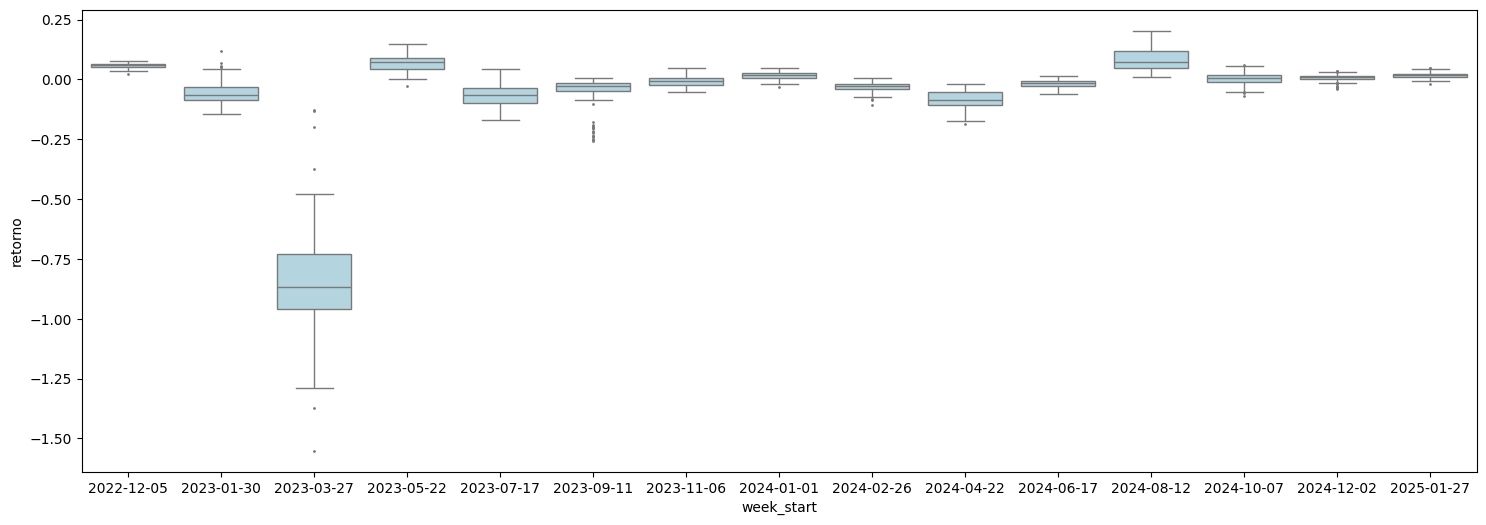

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_boxplot_com_linha_sp500(df_retornos_long, figsize=(18, 6)):
    """
    Plota boxplots dos retornos dos portfólios (por semana)
    com uma linha por cima representando o retorno semanal do S&P 500.

    Parameters
    ----------
    df_retornos_long : DataFrame
        Deve conter as colunas:
        - 'week_start' (datetime)
        - 'retorno'
        - 'tipo': 'portfolio' ou 'sp500'
    """
    df_retornos_long = df_retornos_long.copy()
    df_retornos_long["week_start"] = pd.to_datetime(df_retornos_long["week_start"])

    df_portfolios = df_retornos_long[df_retornos_long["tipo"] == "portfolio"]
    df_sp500 = df_retornos_long[df_retornos_long["tipo"] == "sp500"]

    plt.figure(figsize=figsize)

    # === BOXPLOT dos portfólios (sem 'order'!) ===
    sns.boxplot(
        data=df_portfolios,
        x="week_start", y="retorno",
        color="lightblue",
        fliersize=1
    )

    # === LINHA do S&P 500 ===
    sp500_agrupado = df_sp500.groupby("week_start")["retorno"].mean().sort_index()
    plt.plot(
        sp500_agrupado.index,
        sp500_agrupado.values,
        color="red",
        marker="o",
        linestyle="-",
        label="S&P 500"
    )

    # === Estética ===
    plt.xticks(rotation=90)
    plt.xlabel("Semana")
    plt.ylabel("Retorno log semanal")
    plt.title("Distribuição dos retornos dos portfólios vs. S&P 500")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    fig = plt.gcf()
    plt.close(fig)
    return fig
   

def plot_boxplot_com_linha_sp500_from_df_avaliacao(df_avaliacao, figsize=(18, 6)):
    """
    Gera boxplots dos retornos dos portfólios por date_eval
    e linha do retorno do S&P 500 — usando df_avaliacao.
    """
    # Garantir que date_eval é datetime (caso venha como objeto/str)
    df_av = df_avaliacao.copy()
    df_av["date_eval"] = pd.to_datetime(df_av["date_eval"])

    # ---- Dados dos portfólios ----
    df_portfolios = (
        df_av[["date_eval", "retorno"]]
        .rename(columns={"date_eval": "week_start"})
        .assign(tipo="portfolio")
    )

    # ---- Dados do S&P 500 (um valor por semana) ----
    df_sp500 = (
        df_av[["date_eval", "sp500"]]
        .drop_duplicates()
        .rename(columns={"date_eval": "week_start", "sp500": "retorno"})
        .assign(tipo="sp500")
    )

    # Concatena e garante dtype datetime
    df_long = pd.concat([df_portfolios, df_sp500], ignore_index=True)
    df_long["week_start"] = pd.to_datetime(df_long["week_start"])

    return plot_boxplot_com_linha_sp500(df_long, figsize=figsize)



plot_boxplot_com_linha_sp500_from_df_avaliacao(df_avaliacao)